# Обучение с использованием модели и внутренней мотивации на основе ошибки модели

В данном семинаре рассмотрим вариации модельного обучения на примере табличных алгоритмов. План будет следующий. Вначале мы оттолкнемся от классического алгоритма Dyna-Q — модификации Q-обучения, использующей идеальную табличную модель среды. Данный алгоритм работает с детерминированными средами, а значит обучение модели равносильно запоминанию переходов (т.к. каждый переход можно выучить за один шаг обучения).

После реализации Dyna-Q представим, что модель среды обучается не моментально и может содержать ошибки. Моделируя среду таким образом, мы покроем одновременно два случая: стохастическая среда (распределения переходов придется учить даже в табличном случае) и нейросетевая апроксимация модели (тоже требует постепенного обучения на множестве примеров переходов). Посмотрим для этого варианта, насколько сильно неидеальность обучаемой модели нивелирует преимущества модельного обучения.

Далее посмотрим, как можно построить сигнал внутренней мотивации на основе обучаемой модели и использовать его для ускорения обучения модели и исследования агентом среды. Также попробуем вариацию стратегии генерации воображаемых переходов для обучения стратегии — будем сэмплировать из модели не отдельные случайные переходы (как это сделано в Dyna-Q), а целые воображаемые траектории по аналогии с методами типа Dreamer. Причем эти траектории будут стартовать с текущего состояния агента, имитируя локальное планирование поведения с целью локального доуточнения Q-функции и стратегии по аналогии с методами на базе MCTS (Monte-Carlo Tree Search).

In [ ]:
# try:
#     import google.colab
#     COLAB = True
# except ModuleNotFoundError:
#     COLAB = False
#     pass

# if True:
#     !pip install "gymnasium[classic-control, atari, accept-rom-license]"
#     !pip install piglet
#     !pip install imageio_ffmpeg
#     !pip install moviepy==1.0.3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from collections import deque
from IPython.display import clear_output

%matplotlib inline

In [3]:
def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

/home/nikita/proga/RL/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pc

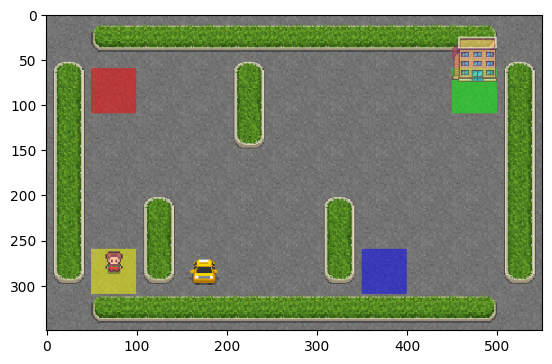

In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

Для начала реализуем класс `Model` обучаемой идеальной модели мира будущего Dyna-Q агента. Некоторые аспекты модели сейчас могут показаться излишними — они нам пригодятся позднее.

(3 балла)

In [16]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        # проинициализируйте атрибуты, необходимые вам для хранения
        # модели (переходов и вознаграждения)
        # например, можно хранить [в виде таблицы] табличные функции
        #        r: (s, a) -> r
        #   next_s: (s, a) -> next_s
        # нужно так же дополнительно держать таблицы масок
        # для посещенных состояний s `mask_state`
        # и пар (s, a) `mask_state_action`
        ####### Здесь ваш код ########
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.r = np.zeros((n_states, n_actions), dtype=int)
        self.next_s = np.zeros((n_states, n_actions), dtype=int)
        
        self.mask_state = np.zeros(n_states, dtype=bool)
        self.mask_state_action = np.zeros((n_states, n_actions), dtype=bool)
        ##############################
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # реализуйте мгновенное обучение модели
        # для (s, a) -> r и (s, a) -> next_s
        # не забудьте пометить посещения в масках
        ####### Здесь ваш код ########
        self.r[s, a] = r
        self.next_s[s, a] = next_s
        
        self.mask_state[s] = True
        self.mask_state_action[s, a] = True
        ##############################
        # вернем также вознаграждение (понадобится позже)
        return r

    def sample_state(self) -> int:
        # просэмплируйте и верните одно посещенное состояние
        ####### Здесь ваш код ########
        visited = np.where(self.mask_state)[0]
        return self._rng.choice(visited)
        ##############################

    def sample_action(self, s) -> int:
        # просэмплируйте и верните одно совершенное ранее действие
        ####### Здесь ваш код ########
        visited = np.where(self.mask_state_action[s])[0]
        return self._rng.choice(visited)
        ##############################

    def predict_transition(self, s, a) -> tuple[float, int, float]:
        # реализуйте [идеальное] предсказание моделей
        # перехода и вознаграждения
        ####### Здесь ваш код ########
        next_s = self.next_s[s, a]
        ##############################
        # дополнительно вернем степень уверенности в предсказании
        # в текущем случае она равна значению в маске (=1)
        confidence = self.mask_state_action[s, a]
        return self.r[s, a], next_s, confidence

    def sample(self) -> tuple[int, int, float, int, float]:
        # реализуйте выбор одного случайного перехода
        # и верните его вместе с уверенностью в предсказании
        # (s, a, r, next_s, confidence)
        ####### Здесь ваш код ########
        s = self.sample_state()
        a = self.sample_action(s)
        r, next_s, confidence = self.predict_transition(s, a)
        return s, a, r, next_s, confidence
        ##############################

Теперь создадим класс `DynaQAgent`, который будет решать задачу обучения методом Dyna-Q, согласно приведенному на рисунке алгоритму:

![dyna](https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/10/dyna.png)

Добавим в реализации возможность выбора исследовательской стратегии между $\epsilon$-жадной и softmax-стратегией. Выбор будет осуществляться на основе передаваемых в конструктор параметров: если передан `eps`, значит первый вариант, если `temp` (температура softmax), то второй.

(2 балла)

In [17]:
def softmax(x, temp: float = 1.0):
    e_x = np.exp((x - np.max(x)) / temp)
    return e_x / np.sum(e_x)

class DynaQAgent:
    def __init__(
        self, n_states, n_actions, lr, gamma, f_model, seed,
        *, eps=None, temp=None
    ):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.temp = temp
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def act(self, s, greedy=False):
        # выбираем действие, используя eps-greedy или softmax
        # исследование среды
        softmax_expl = self.temp is not None

        if softmax_expl and not greedy:
            action = self._rng.choice(
                self.n_actions, p=softmax(self.Q[s], temp=self.temp)
            )
        elif (
            not softmax_expl and not greedy
            and self._rng.random() < self.eps
        ):
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, terminated, update_model: bool):
        if update_model:
            r = self.update_model(s, a, r, s_n)

        # реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        Q_target = r + self.gamma * np.max(self.Q[s_n]) * (not terminated)
        self.Q[s, a] += self.lr * (Q_target - self.Q[s, a])
        ##############################

    def update_model(self, s, a, r, s_n):
        return self.model.add(s, a, r, s_n)

    def dream(self, max_steps, **_):
        # Совершает шаги обучения на `max_steps`
        # сгенрированных моделью переходах
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели на одном
            # сгенерированном моделью переходе
            # NB: будем использовать значение confidence от модели
            # как вероятность использовать сгенерированный переход
            # для шага обучения
            # NB2: флаг `terminated` будем передавать False
            ####### Здесь ваш код ########
            s, a, r, next_s, confidence = self.model.sample()
            if self._rng.random() < confidence:
                self.update(s, a, r, next_s, terminated=False, update_model=False)
            ##############################

In [18]:
def train_episode(rng, env, agent, on_model_updates, is_eval=False):
    """Провести один эпизод обучения или тестирования."""
    state, _ = env.reset(seed=int(rng.integers(1_000_000)))
    episode_return = 0.0
    while True:
        action = agent.act(state, greedy=is_eval)

        # выполняем действие в среде
        next_state, reward, terminated, truncated, info = env.step(action)
        if not is_eval:
            # шаг обучения
            agent.update(
                state, action, reward, next_state, terminated,
                update_model=True
            )
        state = next_state
        episode_return += reward
        if terminated or truncated:
            break
        if not is_eval:
            # шаги обучения по модельным данным
            agent.dream(on_model_updates, state=state)
    return episode_return

def train(
    env, agent, n_episodes, on_model_updates, seed,
    show_progress_schedule=100, show_model_progress=False
):
    train_progress = []
    returns_batch = deque(maxlen=4*show_progress_schedule)
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes+1):
        # один эпизод обучения
        train_episode(rng, env, agent, on_model_updates)
        # и один эпизод тестирования
        returns_batch.append(
            train_episode(rng, env, agent, on_model_updates, is_eval=True)
        )

        if i % show_progress_schedule == 0 and not show_model_progress:
            # график прогресса: отдача за эпизод
            train_progress.append(
                (i, np.mean(returns_batch))
            )
            show_progress(train_progress)
            print(
                f"Episode: {i}, Return: {returns_batch[-1]}, "
                f"AvgReturn[{show_progress_schedule}]: {train_progress[-1][1]:.0f}"
            )
        if i % show_progress_schedule == 0 and show_model_progress:
            # график прогресса: доля выученности посещенных состояний среды
            visited_mask = agent.model.mask_state_action > 0
            avg_model_knowledge = np.mean(
                agent.model.mask_state_action[visited_mask]
            )
            train_progress.append(
                (i, avg_model_knowledge)
            )
            show_progress(train_progress)

    return train_progress

### Q-learning

Обратите внимание, параметр `on_model_updates`, отвечающий на каждом шаге в среде за число дополнительно сгенерированного моделью опыта, равен 0 $\Rightarrow$ значит мы запускаем обычный Q-learning и модель хоть и учим, но ей не пользуемся

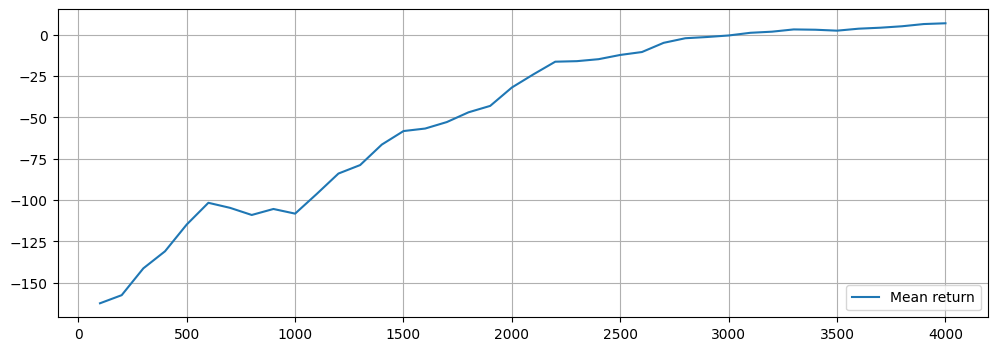

Episode: 4000, Return: 7.0, AvgReturn[100]: 7
CPU times: user 8.6 s, sys: 661 ms, total: 9.26 s
Wall time: 9.15 s


In [47]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=4000, on_model_updates=0, seed=seed)

(1 балл)

### DynaQ

1. Сравните скорость обучения алгоритмов Q-обучение и Dyna-Q с параметром `on_model_updates` равным 10. 
После 1000-го эпизода Dyna-Q уже сходится, в то время как обычный Q-Learning достигает таких же результатов уже после 3500 эпизодов. 
2. Сравните скорость обучения Dyna-Q при различных `on_model_updates`. В каком случае получились лучшие результаты?
При увелечении параметра скорость сходимости по эпизодам растет, но при значениях >50 общее затраченное время гораздо больше и лучше просто увеличить кол-во эпизодов (trade-off). 

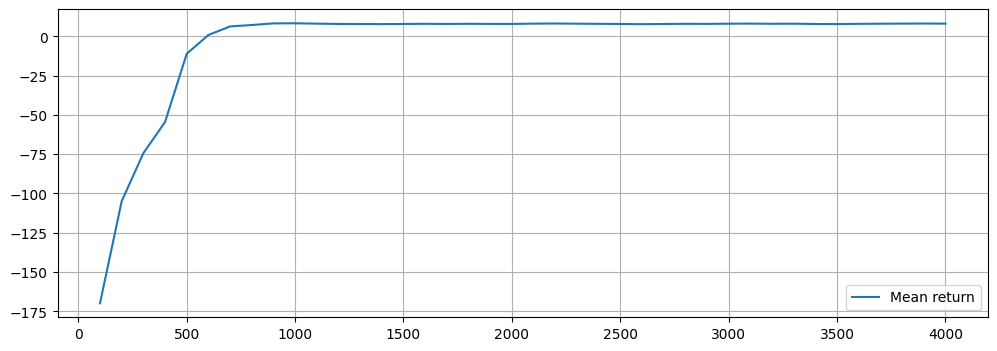

Episode: 4000, Return: 7.0, AvgReturn[100]: 8
CPU times: user 27.7 s, sys: 633 ms, total: 28.3 s
Wall time: 28.3 s


In [83]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=4000, on_model_updates=20, seed=seed)

## Dyna-Q с неидеальной моделью мира

Давайте теперь представим, что мы ничего не знаем о среде. В частности, мы будем даже не уверены в том, что она детерминированная. Будем именно "учить" переходы с некоторой скоростью обучения (параметром `lr` $\in (0, 1)$). Сделаем это следующим образом. Будем продолжать использовать знание о том, что среда такси детерминированная, а значит будем продолжать хранить детерминированную матрицу переходов: $(s, a) \rightarrow s'$. Но если раньше мы также хранили **бинарную** маску "выученности" перехода для пар (s,a): $(s, a) \rightarrow 0 | 1$, то теперь будем хранить **степень** выученности $\in [0, 1]$, где 0 означает полное незнание, а 1 - полное знание. Таким образом каждый шаг обучения модели будем повышать это значение, устремляя его к 1.

Будем интерпретировать степень выученности перехода как уверенность в предсказании и использовать как вероятность дать правильное предсказание перехода данной моделью $P[s_{t+1} |s_t,a_t]$. Тогда в случае планирования будущего моделью, она будет с этой вероятностью давать правильный ответ, а с вероятностью $1 - P[s_{t+1} |s_t,a_t]$ будет давать случайное предсказание.

*NB: можно было бы использовать в качестве аппроксиматора нейронную сеть, но мы сознательно останемся в рамках табличных моделей — именно обучение аппроксиматора и будем сейчас эмулировать, но таким образом, чтобы нам было проще контролировать скорость обучения каждого перехода.*

(2 балла)

In [49]:
class ImperfectModel(Model):
    # обратите внимание, мы наследуемся и переопределяем нужные
    # методы оригинальной идеальной модели

    def __init__(
        self, n_states, n_actions, lr: float, seed: int,
        n_updates: int = 4, buffer_size: int = 1000
    ):
        super().__init__(n_states, n_actions, seed)
        # адаптируйте структуру модели так, чтобы переход (s, a) -> next_s
        # обучался со скоростью `lr`.
        # Для этого поменяем смысл маски посещенных пар (s, a).
        # Заменим бинарную маску на вещественнозначную с числами из [0, 1].
        # Будем интерпретировать их как степень выученности переходов
        # или нашей уверенности в их предсказании
        self.lr = lr
        self.mask_state_action = np.zeros((n_states, n_actions), dtype=float)
        self.buffer = deque(maxlen=buffer_size)
        self.n_updates = n_updates

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # Шаг 1: обновим и положим новый опыт в буфер
        new_transition = s, a, r, next_s
        self._update(*new_transition)
        self.buffer.append(new_transition)

        # Шаг 2: сделаем n_updates итераций обучения модели
        # на данных из буфера
        sz_buffer = len(self.buffer)
        for _ in range(min(self.n_updates, sz_buffer)):
            ix = self._rng.integers(sz_buffer)
            self._update(*self.buffer[ix])
        # вернем входное вознаграждение без изменений
        return r

    def _update(self, s: int, a: int, r: float, next_s: int):
        # сохраняем уверенность в предсказании
        confidence = self.mask_state_action[s][a]
        # воспользуемся шагом обучения идеальной модели
        # NB: она перезатрет self.mask_state_action[s][a]
        super().add(s, a, r, next_s)

        # Сделаем шаг обучения уверенности в предсказании
        # перехода со скоростью `lr`.
        # Для простоты, функцию вознаграждения обучаем мгновенно
        # В идеальной модели было:
        # self.mask_state_action[s][a] = 1
        # Теперь будет:
        self.mask_state_action[s][a] = confidence + self.lr * (1 - confidence)

    def predict_transition(self, s, a) -> tuple[float, int, float]:
        # Реализуйте неидеальное предсказание модели перехода:
        # Используйте величину уверенности как вероятность правильно
        # предсказать переход. Иначе будем выдавать случайное предсказание
        ####### Здесь ваш код ########
        confidence = self.mask_state_action[s, a]
        if self._rng.random() < confidence:
            next_s = self.next_s[s, a]
        else:
            next_s = self._rng.integers(self.n_states)
        ##############################
        return self.r[s, a], next_s, confidence

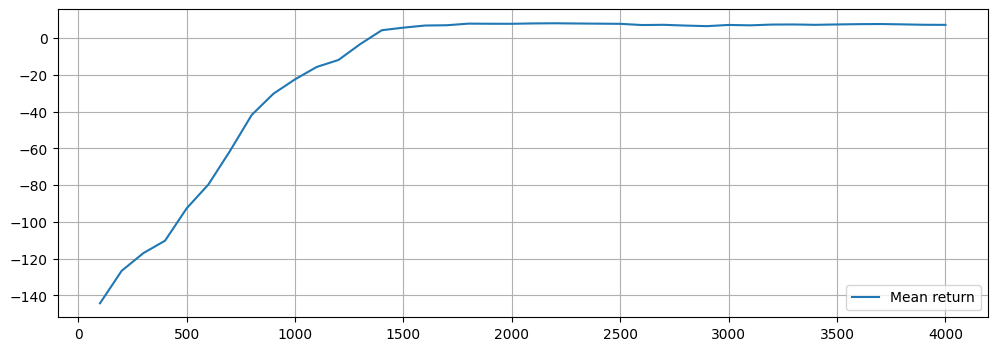

Episode: 4000, Return: 7.0, AvgReturn[100]: 7
CPU times: user 21.9 s, sys: 889 ms, total: 22.8 s
Wall time: 22.7 s


In [72]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=partial(ImperfectModel, lr=0.02, buffer_size=10000, n_updates=5)
)

log_dyna_q_imp = train(
    env, agent, n_episodes=4000, on_model_updates=10, seed=seed
)

**Вопрос на подумать**: Что можно сказать о результатах модельного обучения в случае, когда модель неидеальна?

Скорость сходимости значителньо меньше, по сравнению работы метода с идеальной моделью.

## Dyna-Q с неидеальной моделью и внутренней мотивацией на основе ошибки модели

Сигнал ошибки модели является хорошим сигналом мотивации к исследованию, "отправляя" агента в недоисследованные зоны пространства состояний. Как следствие два плюса: а) более быстрое и целенаправленное обучение самой модели среды (которая дает бонус к скорости обучения через обучение в воображении) и б) более целенаправленное исследование самой среды, которое поможет агенту быстрее найти состояния с высоким внешним вознаграждением.

Давайте посмотрим, так ли это. Реализуйте аналогичную предыдущему пункту "неидеальную" внутреннюю модель среды агента, но теперь также добавьте в нее внутреннюю мотивацию. Для этого можно, например, добавлять ошибку предсказания на основе вероятности дать случайное предсказание $1 - P[s_{t+1} |s_t,a_t]$ к полученному внешнему вознаграждению $r_{t+1}$ при обучении функции вознаграждения.

In [51]:
class IntrinsicMotivationModel(ImperfectModel):
    def __init__(
        self, n_states, n_actions, lr: float, seed: int,
        n_updates: int = 4, buffer_size: int = 1000,
        add_intrinsic: float=0.
    ):
        super().__init__(
            n_states, n_actions, lr, seed,
            n_updates=n_updates, buffer_size=buffer_size
        )
        self.add_intrinsic = add_intrinsic

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        super().add(s, a, r, next_s)

        # вернем вознаграждение реального перехода
        # с добавкой внутренней мотивации
        r += self._get_intrinsic_reward(s, a)
        return r

    def sample(self) -> tuple[int, int, float, int, float]:
        s, a, r, next_s, confidence = super().sample()

        # вернем вознаграждение предсказанного перехода
        # с добавкой внутренней мотивации
        r += self._get_intrinsic_reward(s, a)
        return s, a, r, next_s, confidence

    def _get_intrinsic_reward(self, s, a):
        # вычислите значение сигнала внутренней мотивации r_im
        # можете адаптировать код ниже.
        r_im = 0.0
        confidence = self.mask_state_action[s][a]
        if self.add_intrinsic > 0.:
            r_im = 1.0 - confidence**3
        return self.add_intrinsic * r_im

Сначала проверим, что все запускается и работает: масштабирующий коэффициент добавочной внутренней мотивации `add_intrinsic` равен 0 $\Rightarrow$ это обычное модельное обучение с неидеальной моделью как в подпункте выше, просто теперь мы использовали объект модели нового класса. Графики должны совпадать

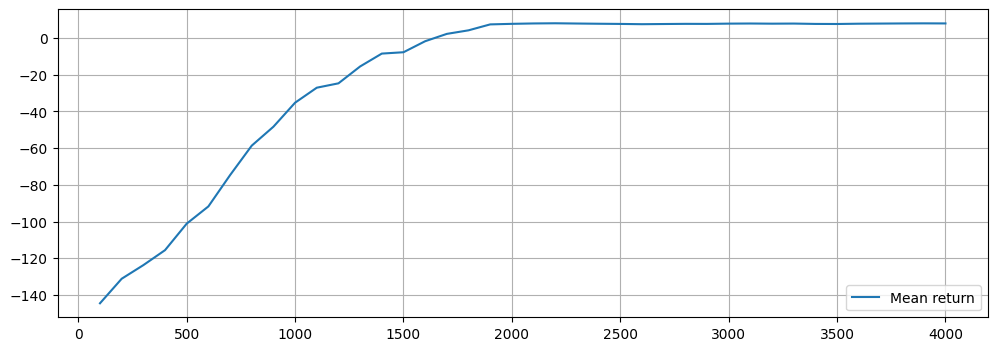

Episode: 4000, Return: 7.0, AvgReturn[100]: 8
CPU times: user 16.8 s, sys: 402 ms, total: 17.2 s
Wall time: 17 s


In [52]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.02, buffer_size=10000, n_updates=5,
        add_intrinsic=0.
    )
)

log_dyna_q_imp_im = train(
    env, agent, n_episodes=4000, on_model_updates=5, seed=seed
)

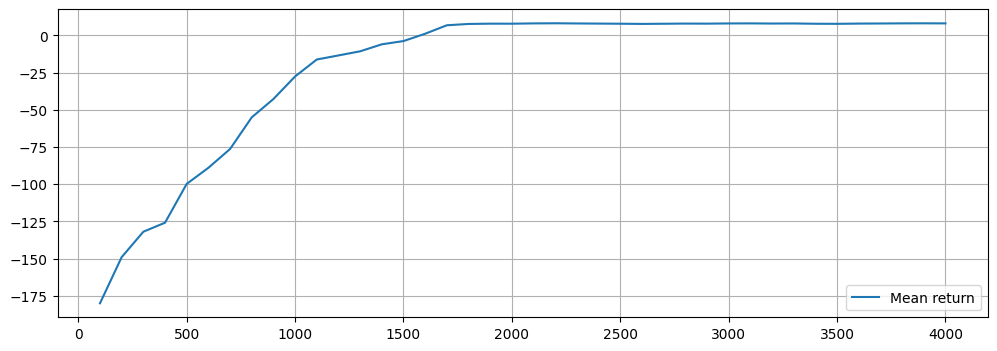

Episode: 4000, Return: 7.0, AvgReturn[100]: 8
CPU times: user 15.6 s, sys: 383 ms, total: 15.9 s
Wall time: 15.9 s


In [53]:
%%time
# а теперь со включенной внутренней мотивацией (см add_intrinsic параметр)
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.025, buffer_size=10000, n_updates=5,
        add_intrinsic=0.1
    )
)

log_dyna_q_imp_im = train(
    env, agent, n_episodes=4000, on_model_updates=5, seed=seed
)

## With imaginary trajectories
До этого процесс обучения по модельным данным происходил беспорядочно — агент случайно сэмплировал состояние, которое ему знакомо, выбирал случайно действие, которое однажды уже выбирал, предсказывал переход (следующее состояние и вознаграждение) и обучался на одном переходе. Процесс повторялся в течение нескольких независимых шагов.

Теперь давайте попробуем воспроизвести процесс обучения в воображении, похожий на планирование из текущей позиции — чтобы агент воображал целую траекторию, начинающуюся с текущего состояния (то есть додумывал/планировал возможное продолжение событий, начиная с текущего момента).

(2 балла)

In [54]:
class DynaQDreamingAgent(DynaQAgent):
    def dream(self, max_steps, state):
        # текущее состояние — стартовое для траектории длины max_steps в воображении
        s = state
        for _ in range(max_steps):
            # добавьте последовательный шаг в воображении с шагом обучения
            # Действие теперь будем выбирать на основе
            # исследовательской стратегии агента
            # Будем прерывать генерацию траектории на основе
            # уверенности перехода с вероятностью `1 - confidence`
            ####### Здесь ваш код ########
            a = self.act(s, greedy=False)
            r, next_s, confidence = self.model.predict_transition(s, a)
            if self._rng.random() < confidence:
                self.update(s, a, r, next_s, terminated=False, update_model=False)
                s = next_s
            else:
                break
            ##############################

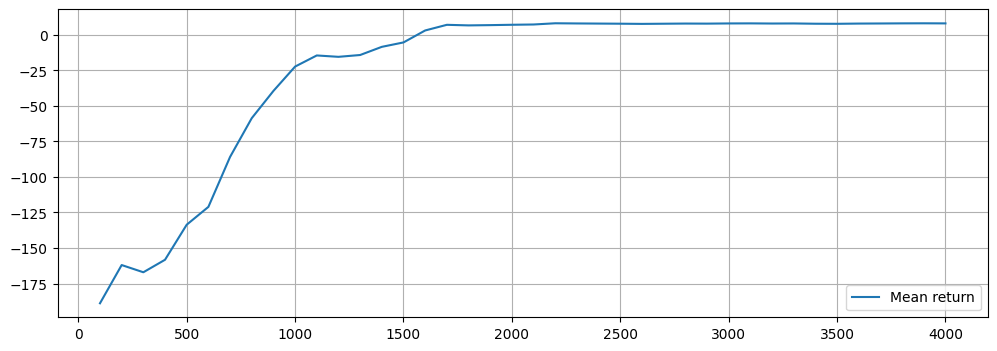

Episode: 4000, Return: 7.0, AvgReturn[100]: 8
CPU times: user 13.4 s, sys: 583 ms, total: 13.9 s
Wall time: 13.7 s


In [55]:
%%time
# сначала без внутренней мотивации
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.025, buffer_size=10000, n_updates=5,
        add_intrinsic=0.
    )
)

log_dyna_q_imp_dreamer = train(
    env, agent, n_episodes=4000, on_model_updates=5, seed=seed
)

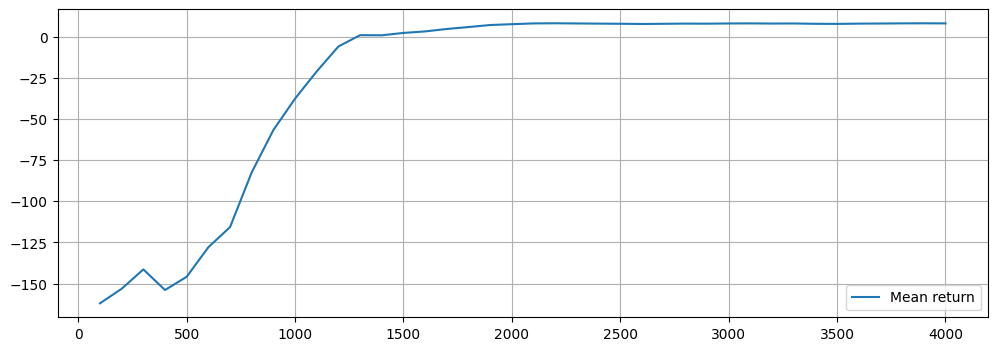

Episode: 4000, Return: 7.0, AvgReturn[100]: 8
CPU times: user 13 s, sys: 447 ms, total: 13.5 s
Wall time: 13.5 s


In [56]:
%%time
# и то же самое с внутренней мотивацией
env = gym.make("Taxi-v3", max_episode_steps=100)
seed = 1337
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.1,
    gamma=0.975, temp=0.25, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.025, buffer_size=10000, n_updates=5,
        add_intrinsic=0.1
    )
)

log_dyna_q_imp_im_dreamer = train(
    env, agent, n_episodes=4000, on_model_updates=4, seed=seed
)

## Сравнение подходов
Теперь просимулируем задачу посложнее и сравним результаты. В качестве усложнения выбраны:

- более жесткое ограничение на длину эпизода max_episode_steps = 50
- меньшая скорость обучения lr Q-функции и модели
- более жадная стратегия исследования (ниже температура софтмакса)

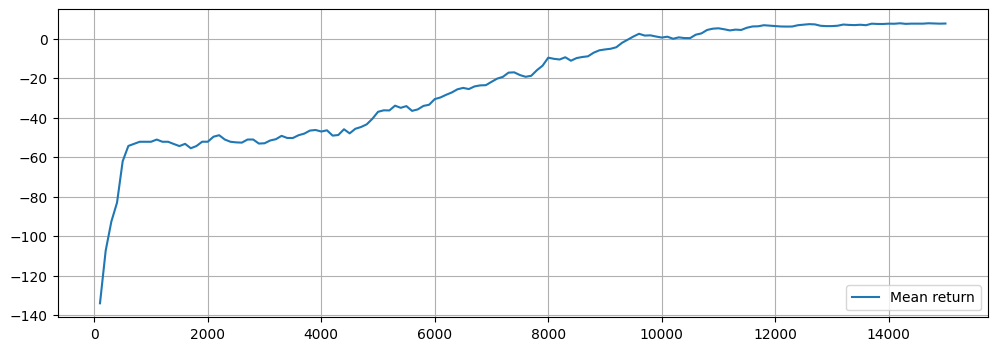

Episode: 15000, Return: 9.0, AvgReturn[100]: 8
CPU times: user 26.3 s, sys: 1.68 s, total: 28 s
Wall time: 27.5 s


In [57]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=Model
)

log_q = train(
    env, agent, n_episodes=15000, on_model_updates=0, seed=seed,
)

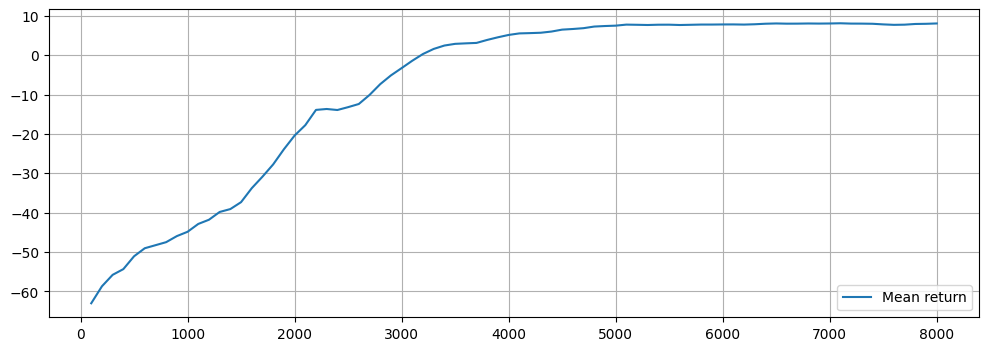

Episode: 8000, Return: 6.0, AvgReturn[100]: 8
CPU times: user 25.6 s, sys: 745 ms, total: 26.4 s
Wall time: 26.1 s


In [58]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, n_episodes=8000, on_model_updates=5, seed=seed)

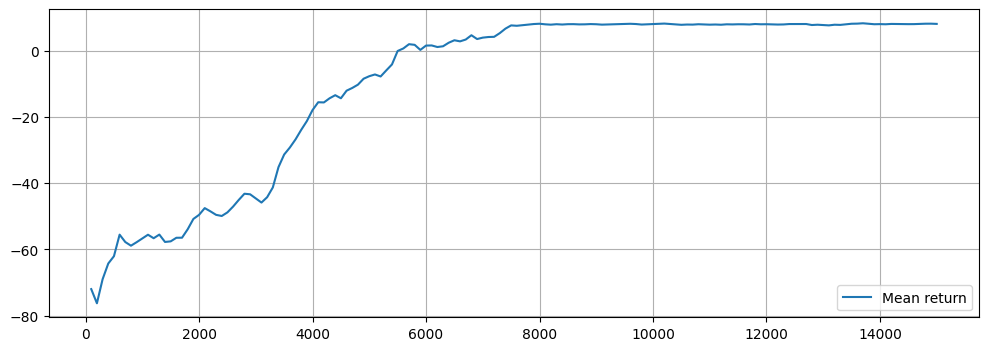

Episode: 15000, Return: 9.0, AvgReturn[100]: 8
CPU times: user 52.4 s, sys: 1.62 s, total: 54.1 s
Wall time: 53.5 s


In [73]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.004, buffer_size=10000, n_updates=5)
)

log_dyna_q_imp = train(
    env, agent, n_episodes=15000, on_model_updates=5, seed=seed
)

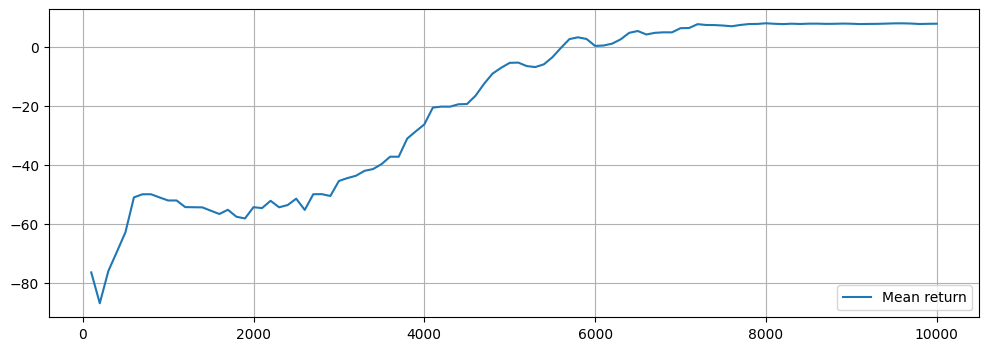

Episode: 10000, Return: 6.0, AvgReturn[100]: 8
CPU times: user 41.1 s, sys: 1.13 s, total: 42.2 s
Wall time: 42 s


In [74]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5,
        add_intrinsic=0.1
    )
)

log_dyna_q_imp_im = train(
    env, agent, n_episodes=10000, on_model_updates=5, seed=seed
)

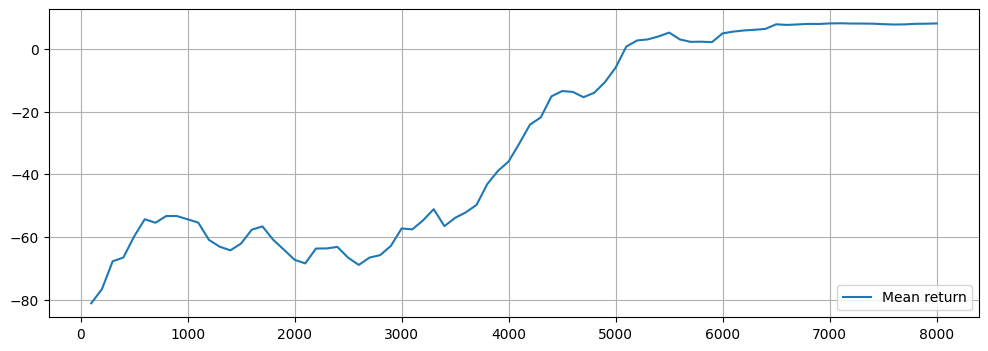

Episode: 8000, Return: 6.0, AvgReturn[100]: 8
CPU times: user 31.8 s, sys: 1.89 s, total: 33.6 s
Wall time: 33.2 s


In [75]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5, add_intrinsic=0.
    )
)

log_dyna_q_imp_dreaming = train(
    env, agent, n_episodes=8000, on_model_updates=5, seed=seed
)

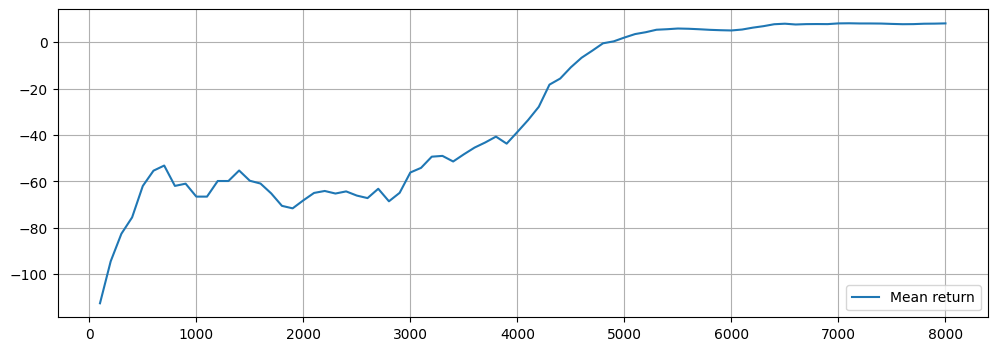

Episode: 8000, Return: 6.0, AvgReturn[100]: 8
CPU times: user 31.6 s, sys: 2.09 s, total: 33.7 s
Wall time: 33.1 s


In [76]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5, add_intrinsic=0.1
    )
)

log_dyna_q_imp_im_dreaming = train(
    env, agent, n_episodes=8000, on_model_updates=5, seed=seed
)

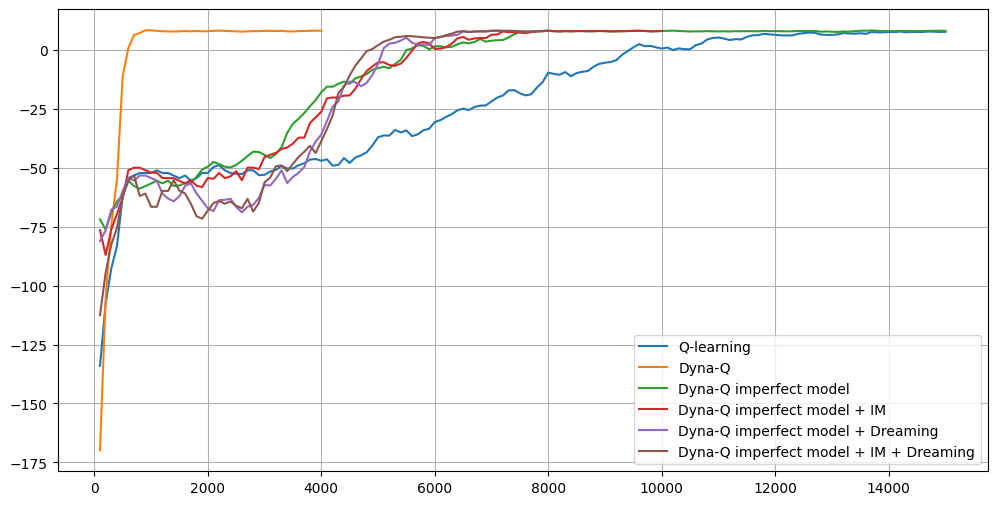

In [77]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM'),
    (log_dyna_q_imp_dreaming, 'Dyna-Q imperfect model + Dreaming'),
    (log_dyna_q_imp_im_dreaming, 'Dyna-Q imperfect model + IM + Dreaming'),
])

## Model learning progress

Теперь давайте запустим те же самые эксперименты, но отрисуем средний прогресс обучения переходов в модели (0 — модель полностью необучена, 1 — модель полностью обучила все возможные переходы) и посмотрим, насколько велика разница в скорости исследования среды и обучения модели.

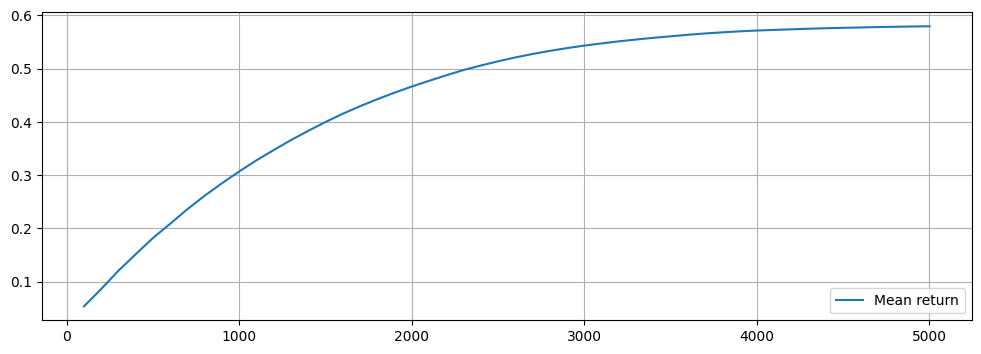

CPU times: user 26.9 s, sys: 411 ms, total: 27.3 s
Wall time: 27.1 s


In [78]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.004)
)

_log_dyna_q_imp = train(
    env, agent, n_episodes=5000, on_model_updates=5, seed=seed,
    show_model_progress=True
)

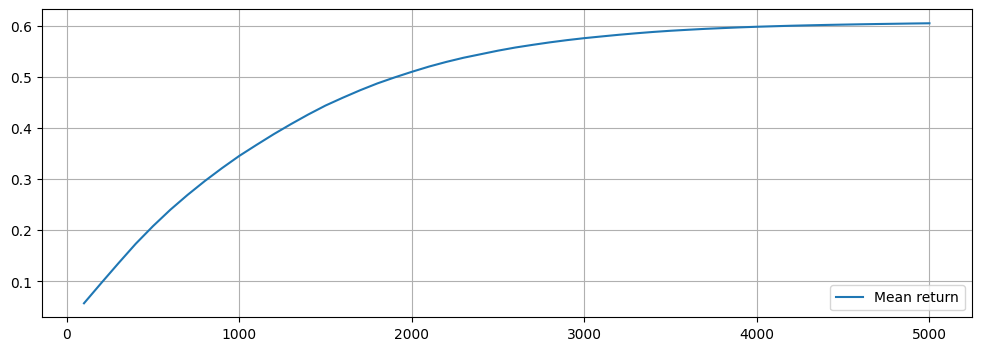

CPU times: user 24.8 s, sys: 488 ms, total: 25.3 s
Wall time: 25.1 s


In [79]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.975, eps=0.02, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5,
        add_intrinsic=0.1
    )
)

_log_dyna_q_imp_im = train(
    env, agent, n_episodes=5000, on_model_updates=5, seed=seed,
    show_model_progress=True
)

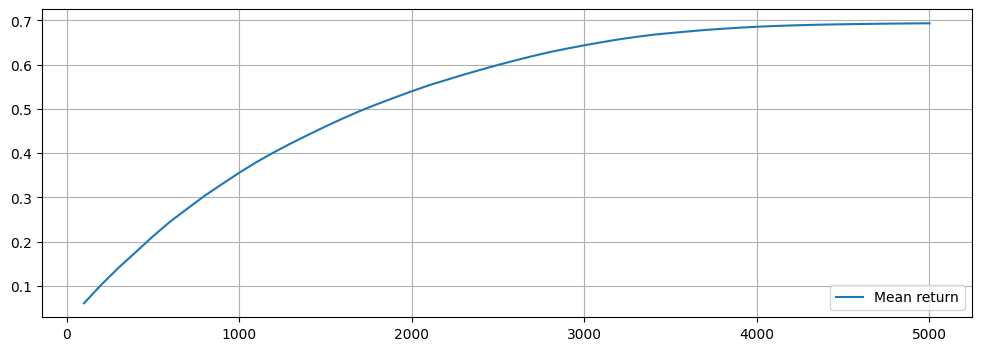

CPU times: user 23 s, sys: 731 ms, total: 23.7 s
Wall time: 23.6 s


In [80]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5,
        add_intrinsic=0.
    )
)

_log_dyna_q_imp_dreaming = train(
    env, agent, n_episodes=5000, on_model_updates=5, seed=seed,
    show_model_progress=True
)

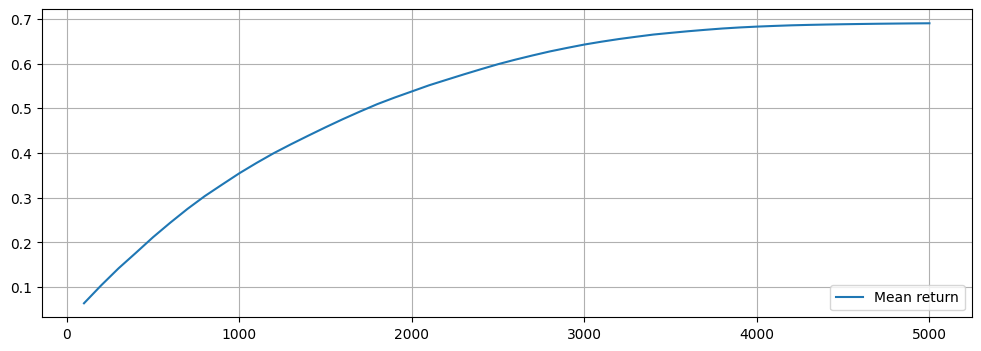

CPU times: user 22.7 s, sys: 649 ms, total: 23.3 s
Wall time: 23.2 s


In [81]:
%%time
env = gym.make("Taxi-v3", max_episode_steps=50)
seed = 42
agent = DynaQDreamingAgent(
    env.observation_space.n, env.action_space.n, lr=0.03,
    gamma=0.98, temp=0.1, seed=seed,
    f_model=partial(
        IntrinsicMotivationModel, lr=0.004, buffer_size=10000, n_updates=5,
        add_intrinsic=0.1
    )
)

_log_dyna_q_imp_im_dreaming = train(
    env, agent, n_episodes=5000, on_model_updates=5, seed=seed,
    show_model_progress=True
)

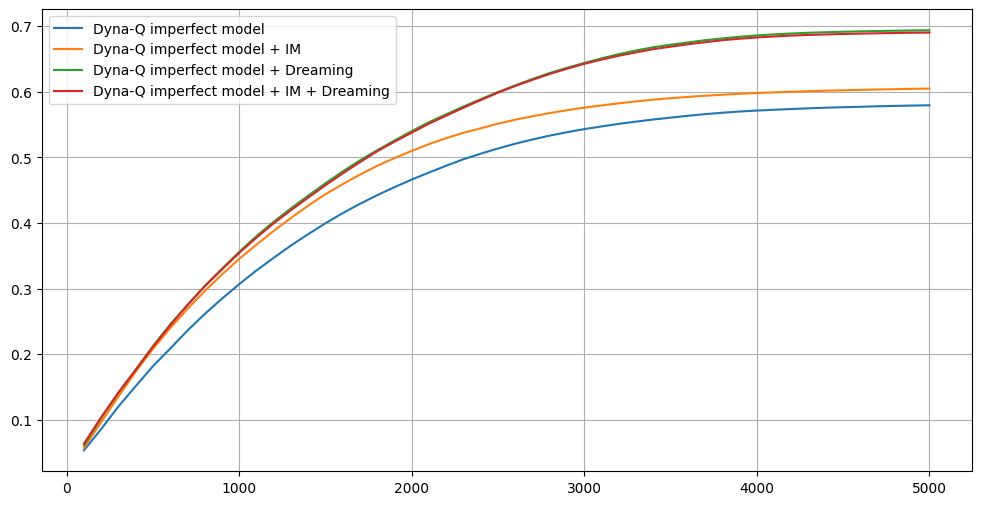

In [82]:
compare_logs([
    (_log_dyna_q_imp, 'Dyna-Q imperfect model'),
    (_log_dyna_q_imp_im, 'Dyna-Q imperfect model + IM'),
    (_log_dyna_q_imp_dreaming, 'Dyna-Q imperfect model + Dreaming'),
    (_log_dyna_q_imp_im_dreaming, 'Dyna-Q imperfect model + IM + Dreaming'),
])